# Tache de classification sur des articles de journal. 

The Fake News Classification Dataset is an English-language dataset containing just over 45,000 unique news articles. These articles are classified as true (1) or false (0)

link : https://www.kaggle.com/datasets/aadyasingh55/fake-news-classification/data

## Load modules

In [1]:
import numpy as np
import pandas as pd 
from pandas import DataFrame

import os,re
from pathlib import Path
import multiprocessing
import tqdm
import importlib
from datetime import datetime 


#Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

#Kagglehub
import kagglehub

from IPython.display import display, HTML
from functools import partial



from sklearn.metrics import precision_score, recall_score, f1_score


#NLP modules
from tokenizers import (
    Tokenizer,
    normalizers,
    pre_tokenizers,
    trainers)
from tokenizers.models import BPE

from collections import Counter
from wordcloud import WordCloud

from gensim.models import Word2Vec

# Download stopwords if not already downloaded
import nltk
from nltk.corpus import stopwords


#Deeplearning with Pytorch
import torch 
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from datasets import Dataset

/home/ivanhoe/Bureau/NLP_presentation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Initialisation
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # CPU or GPU 
print(cores,device)

12 cuda:0


## Load dataset from Kaggle

In [3]:
os.makedirs("../data/tp1",exist_ok=True)

# Download the dataset
path = kagglehub.dataset_download("aadyasingh55/fake-news-classification",force_download=True)

for dirname, _, filenames in os.walk(path):
    print(dirname)
    print(_)
    print(filenames)
    for filename in filenames:
        Path(os.path.join(dirname, filename)).rename(os.path.join("../data/tp1", filename))


100%|██████████| 39.0M/39.0M [00:02<00:00, 20.2MB/s]

Extracting files...


/home/ivanhoe/.cache/kagglehub/datasets/aadyasingh55/fake-news-classification/versions/1
[]
['train (2).csv', 'test (1).csv', 'evaluation.csv']


In [4]:
!file -i "../data/tp1/train (2).csv"

../data/tp1/train (2).csv: text/plain; charset=utf-8


In [5]:

path_train = os.path.join("../data/tp1", "train (2).csv")
path_test = os.path.join("../data/tp1", "test (1).csv")
path_eval= os.path.join("../data/tp1","evaluation.csv" )

encoding='utf-8'

# Load training data
try:
    train_df = pd.read_csv(path_train, on_bad_lines='skip',sep=';',index_col=0,encoding=encoding)
    print("Train dataset loaded successfully.")
except Exception as e:
    print(f"Error loading train dataset: {e}")

# Load evaluation data
try:
    eval_df = pd.read_csv(path_eval, on_bad_lines='skip',sep=';',index_col=0,encoding=encoding)
    print("Evaluation dataset loaded successfully.")
except Exception as e:
    print(f"Error loading evaluation dataset: {e}")

# Load test data
try:
    test_df = pd.read_csv(path_test, on_bad_lines='skip',sep=';',index_col=0,encoding=encoding)
    print("Test dataset loaded successfully.")
except Exception as e:
    print(f"Error loading test dataset: {e}")


Train dataset loaded successfully.
Evaluation dataset loaded successfully.
Test dataset loaded successfully.


In [6]:
print(train_df.info())
print(eval_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 24353 entries, 0 to 24352
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   24353 non-null  object
 1   text    24353 non-null  object
 2   label   24353 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 761.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 8117 entries, 0 to 8116
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   8117 non-null   object
 1   text    8117 non-null   object
 2   label   8117 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 253.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 8117 entries, 0 to 8116
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   8117 non-null   object
 1   text    8117 non-null   object
 2   label   8117 non-null   int64 
dtypes: int64(1), object(2)
memory usage:

## Visualisation des données 

### Question 1 :
- Compléter la fonction "display_random_sample" pour permettre d'afficher de manière aléatoire des exemples du jeu de données.
- Créer une colonne ("content") qui est la concaténation du titre et de l'article.
- visualiser la répartition des classes entre les faux et les vrais articles. 

In [7]:
def display_random_sample(dataset:DataFrame, num_examples:int=1)->None:

    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset." # A way to raise an error if it's not true
    sample_df = dataset.sample(num_examples)

    display(HTML(sample_df.to_html()))

display_random_sample(train_df,3) 

In [8]:
train_df['content'] = train_df['title'] + " " + train_df['text']  # Combine title and text
eval_df['content'] = eval_df['title'] + " " + eval_df['text']
test_df['content'] = test_df['title'] + " " + test_df['text']

label
1    0.540173
0    0.459827
Name: count, dtype: float64


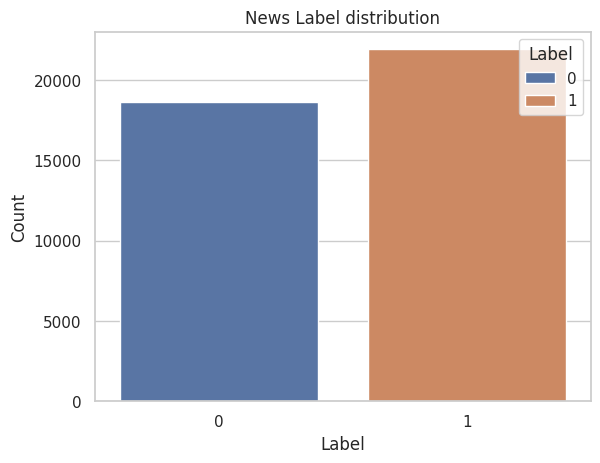

In [9]:
concat_df = pd.concat([train_df,test_df,eval_df])
category_counts = concat_df['label'].value_counts().reset_index()
category_counts.columns = ['Label', 'Count']

sns.set_theme(style="whitegrid")
sns.barplot(x='Label', y='Count', data=category_counts,hue = 'Label',legend=True)

plt.title("News Label distribution")
plt.xlabel("Label")
plt.ylabel("Count")

print(concat_df['label'].value_counts()/len(concat_df))

# Normalization des données, entrainer un tokenizer et visualisation 

### Question 2 :
À l'aide des deux liens ci-dessous, entraîner un tokenizer BPE sur l'ensemble de votre jeu de données.


Build a tokenizer from scratch = https://huggingface.co/docs/tokenizers/quicktour

Building a tokenizer, block by block = https://huggingface.co/learn/nlp-course/chapter6/8

In [10]:

# Function to generate training corpus from dataset
def get_training_corpus(dataset, column_name="content"):
    for i in range(0, len(dataset), 1000):
        yield dataset[column_name].iloc[i : i + 1000].astype(str).tolist()

# Initialize the tokenizer with a BPE model
tokenizer = Tokenizer(BPE())

# Set normalizers (optional: lowercase, NFD, etc.)
tokenizer.normalizer = normalizers.Sequence([normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()])

# Set pre-tokenizer
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace() # pre_tokenizers.ByteLevel(add_prefix_space=True) #

# Define the BPE trainer with a vacab_size = 25_000
trainer = trainers.BpeTrainer(vocab_size=25_000)

# Train the tokenizer
tokenizer.train_from_iterator(get_training_corpus(pd.concat([train_df,eval_df],axis=0)), trainer=trainer)


In [11]:
os.makedirs("../data/tokenizers",exist_ok=True)
#Save the tokenizer
tokenizer.save("../data/tokenizers/tokenizer.json")

In [12]:

#load the tokenizer
tokenizer = Tokenizer.from_file("../data/tokenizers/tokenizer.json")

### Question 3 : 
Expliquer les sorties de "tokenizer.encode(txt)", ajouter une nouvelle colonne aux datasets avec la liste des "ids" pour chaque "content". 

In [13]:
#Sample 1 original content
sample_text = train_df.sample().content.values[0]

# Encode the sample text using the tokenizer
encoded_output = tokenizer.encode(sample_text)

# Print results in a structured way
print("Original Text:")
print(sample_text)

print("\nTokenized Output (Tokens):")
print(encoded_output.tokens)

print("\nTokenized Output (IDs):")
print(encoded_output.ids)

print("\nNumber of Tokens:")
print(len(encoded_output.ids))

print("\nDecoded Text:")
print(tokenizer.decode(encoded_output.ids))

Original Text:
G5 Sahel launches military operation in African scrublands DAKAR (Reuters) - A long-awaited multi-national military force in Africa s Sahel region has begun operations to counter escalating Islamist insurgencies, participants in the joint effort said on Thursday.     The G5 Sahel force, backed by France and the United States, launched its campaign on Oct. 28 amid growing unrest in the desert reaches of the Sahel, where jihadists such as al Qaeda and Islamic State-affiliated groups roam undetected, often across long, porous borders.  Last month, Islamist militants killed four U.S. soldiers and at least four Nigeriens in an ambush that highlighted the risks of operating in the remote region. G5 Sahel is made up of troops from Mali, Niger, Chad, Burkina Faso and Mauritania that will police the region in collaboration with 4,000 French troops deployed there since intervening in 2013 to beat back an insurgency in northern Mali.  The first mission, called  HAW BI , comprises s

In [14]:
exemple_df = train_df.sample(10)
exemple_df["tokens"] = exemple_df["content"].apply(lambda txt : tokenizer.encode(txt).tokens)
exemple_df["ids"]= exemple_df["content"].apply(lambda txt : tokenizer.encode(txt).ids) 

display_random_sample(exemple_df[["content","ids","tokens"]],1) 

### question 4 :
Proposer une visualisation sous forme de nuage de mots pour les faux  et les vrais articles. Vous pourrez exclure les mots de liaisons et la ponctuation ("a", "the", "," ...) qui n'apportent pas d'information en utilisant la bibliothèque "nlk" et sa base de "stop_word" en anglais. 

In [15]:

concat_df = pd.concat([train_df,eval_df],axis=0)
concat_df["tokens"] = concat_df["content"].apply(lambda txt : tokenizer.encode(txt).tokens)
concat_df["ids"]= concat_df["content"].apply(lambda txt : tokenizer.encode(txt).ids) 

# Step 1: Extract Vocabulary
vocab = tokenizer.get_vocab()  # Returns a dictionary {word: token_id}
id_to_word = {id: word for word, id in vocab.items()}  # Reverse mapping


# Step 2: Count Word Frequencies
# Flatten the list of token IDs
all_ids  = [id for ids in concat_df["ids"] for id in ids]
all_ids_fake = [id for ids in concat_df[concat_df["label"] == 0]["ids"] for id in ids]
all_ids_true = [id for ids in concat_df[concat_df["label"] == 1]["ids"] for id in ids]

# Count the frequency of each token ID
id_counts = Counter(all_ids)
id_counts_fake = Counter(all_ids_fake)
id_counts_true = Counter(all_ids_true)

# Step 3: Map Token IDs to Words
# Convert token frequencies to word frequencies
word_frequencies = {id_to_word[id]: count for id, count in id_counts.items() if id in id_to_word}
word_frequencies_fake = {id_to_word[id]: count for id, count in id_counts_fake.items() if id in id_to_word}
word_frequencies_true = {id_to_word[id]: count for id, count in id_counts_true.items() if id in id_to_word}


In [16]:
nltk.download('stopwords')

ponctuation_set = {'(', ')', ',', '-', '.', ':', '’', '“'}
# Get the English stop word list and add your ponctuation stop word set
stop_words = set(stopwords.words('english')).union(ponctuation_set)

# Stop word filtration 
filtered_word_frequencies = {word: count for word, count in word_frequencies.items() if word.lower() not in stop_words}
filtered_word_frequencies_fake = {word: count for word, count in word_frequencies_fake.items() if word.lower() not in stop_words}
filtered_word_frequencies_true = {word: count for word, count in word_frequencies_true.items() if word.lower() not in stop_words}

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ivanhoe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


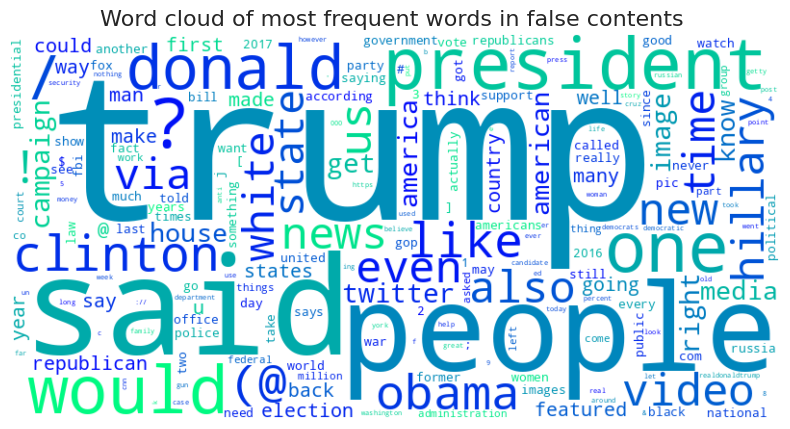

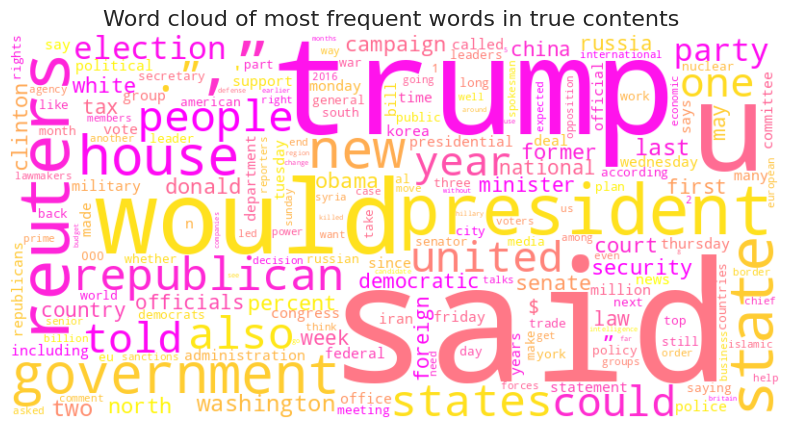

In [17]:
# Step 4: Generate Word Cloud
#link : https://www.kaggle.com/code/niteshhalai/wordcloud-colormap

# Create the WordCloud object
wordcloud_fake = WordCloud(width=800, height=400, background_color="white",colormap="winter").generate_from_frequencies(filtered_word_frequencies_fake)
wordcloud_true = WordCloud(width=800, height=400, background_color="white",colormap="spring").generate_from_frequencies(filtered_word_frequencies_true)

# Display the Word Cloud of fake content 
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation="bilinear")
plt.axis("off")
plt.title("Word cloud of most frequent words in false contents ", fontsize=16)
plt.show()

# Display the Word Cloud of true content 
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_true, interpolation="bilinear")
plt.axis("off")
plt.title("Word cloud of most frequent words in true contents ", fontsize=16)
plt.show()

#### Question 5 :  
En utilisant la bibliothèque Gesim entrainer un model Word2Vec avec votre jeu de données et votre tokenizer. Explorer ensuite les représentations vectorielles renvoyées par le model sur quelques exemples ("trump", "said", "president", "people", ...)

link1 : https://medium.com/@manansuri/a-dummys-guide-to-word2vec-456444f3c673

link2 : https://radimrehurek.com/gensim/models/word2vec.html

link3 : https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial


In [18]:

class MyIter:

    def __init__(self,sentences,tokenizer):
        self.sentences = sentences
        self.tokenizer = tokenizer

    def __iter__(self):

        for sentence in self.sentences:
            yield list(tokenizer.encode(sentence).tokens)


concat_df = pd.concat([train_df,eval_df],axis=0)

sentences_iterator = MyIter(sentences = concat_df["content"].to_list(),tokenizer=tokenizer)

In [19]:
w2v_model = Word2Vec(vector_size=100, window=5, min_count=1, sg=1, workers=cores,compute_loss=True) 

w2v_model.build_vocab(sentences_iterator)  # prepare the model vocabulary

for epoch in tqdm.tqdm(range(5)):
    w2v_model.train(sentences_iterator, total_examples=w2v_model.corpus_count, epochs=1)  # train word vectors
   


100%|██████████| 5/5 [02:57<00:00, 35.45s/it]


In [20]:
os.makedirs("../models_checkpoints/tp1",exist_ok=True)
#save the model Word2Vec 
w2v_model.save("../models_checkpoints/tp1/fakenews_word2vec.model")

In [21]:
w2v_model = Word2Vec.load("../models_checkpoints/tp1/fakenews_word2vec.model")

#### Exploration des embeddings 

In [22]:
w2v_model.wv.most_similar(positive=["trump"])

[('donald', 0.8367687463760376),
 ('obama', 0.6688086986541748),
 ('elect', 0.6542306542396545),
 ('conway', 0.6404138803482056),
 ('birtherism', 0.6332717537879944),
 ('mccarthyism', 0.6328748464584351),
 ('presidentelect', 0.6309529542922974),
 ('trumps', 0.6219663619995117),
 ('yuge', 0.6187419295310974),
 ('pence', 0.6144120693206787)]

In [23]:
w2v_model.wv.most_similar(positive=["president"])

[('presidency', 0.6850294470787048),
 ('barack', 0.653967559337616),
 ('elect', 0.6423090100288391),
 ('administration', 0.5933665633201599),
 ('donald', 0.5912024974822998),
 ('presidents', 0.5844058990478516),
 ('presidentelect', 0.5815923810005188),
 ('45th', 0.5796428918838501),
 ('inaugurated', 0.5757145881652832),
 ('sarkozy', 0.5757034420967102)]

In [24]:
w2v_model.wv.most_similar(positive=["said"])

[('added', 0.8282420635223389),
 ('told', 0.7848072648048401),
 ('adding', 0.7270877361297607),
 ('stressed', 0.6861693859100342),
 ('warned', 0.68366938829422),
 ('acknowledged', 0.6800640821456909),
 ('reporters', 0.6527056694030762),
 ('suggested', 0.6399046182632446),
 ('wrote', 0.634911835193634),
 ('conceded', 0.6348715424537659)]

# Entrainer un modèle de classification avec des poids aléatoires 

### Question 6 : 

* Construire des datasets train, eval et test avec la classe Dataset. 

link1 : https://plainenglish.io/blog/understanding-collate-fn-in-pytorch-f9d1742647d3

link2 : http://www.idris.fr/jean-zay/gpu/jean-zay-gpu-torch-data-preprocessing.html

* Ajout d'une colonne "input_ids" avec la méthode map

link : https://medium.com/@sujathamudadla1213/what-are-some-benefits-of-using-the-dataset-map-7dab03afb6d3

* Ajouter un index de padding pour les positions a ignorer par le modèle où encore pour compléter dans chaque batch pour obtenir une matrice

* Construire des dataloaders associés qui rajoutent le padding pour chaque batch.


In [25]:
#transforme a pandas df to a torch dataset object 
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)
test_dataset = Dataset.from_pandas(test_df)

In [26]:

# Define a function for tokenization
def tokenize_function(example):
    tokens = tokenizer.encode(example["content"]).ids
    return {"input_ids": tokens}

train_dataset = train_dataset.map(tokenize_function)
eval_dataset = eval_dataset.map(tokenize_function)
test_dataset = test_dataset.map(tokenize_function)


Map: 100%|██████████| 8117/8117 [00:10<00:00, 774.80 examples/s]


In [27]:
# Creation d'un index de padding pour les positions a ignorer par le modèle où encore pour compléter dans chaque batch pour obtenir une matrice
pad_idx = tokenizer.get_vocab_size()

print("L'index de padding est :", pad_idx)

L'index de padding est : 25000


In [28]:
# Define the custom collate function
def collate_fn(batch):
    """
    Custom collate function for padding.
    """
    # for item in batch:
    #     print(item["input_ids"])
    
    #convert "input_ids" to torch.Tensor
    tokenized_contents = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch] #self.long() is equivalent to self.to(torch.int64)

    # Pad the tokenized content
    padded_contents = pad_sequence(tokenized_contents, batch_first=True, padding_value=pad_idx)

    #  Extract  and convert labels to a tensor 
    labels = [item["label"] for item in batch] 
    labels = torch.tensor(labels, dtype=torch.long)

    return {
        "input_ids": padded_contents,
        "labels": labels,
    }


In [29]:

# Create a DataLoader
batch_size = 64

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle the data for training
    collate_fn=collate_fn  # Use custom collate function
)


eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle the data for training
    collate_fn=collate_fn  # Use custom collate function
)


test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle the data for training
    collate_fn=collate_fn  # Use custom collate function
)


In [30]:
# Example usage
for batch in train_dataloader:
    #print(batch["input_ids"])
    print(batch["input_ids"].shape)  # Shape of the input_ids tensor
    #print(batch["labels"])
    print(batch["labels"].shape)  # Shape of the labels tensor
    break

torch.Size([64, 6283])
torch.Size([64])


### Question 7 :

Developper une architecture de modèle héritant de la classe "nn.Module" qui converti les "input_ids" en embeddings, les moyennes pour donner une représentation vectorielle à chaque article. Le modèle doit renvoyer une prédiction entre deux classes :

link1 : https://medium.com/@spandey8312/text-classification-using-custom-data-and-pytorch-d88ba1087045

Remarque : vous pourrez utiliser le model Word2Vec précédemment entrainé pour initialiser la table d'embeddings du classifier  


##### Architecture 1

In [31]:
class TextClassifierMean(nn.Module):

    def __init__(self, vocab_size, embedding_dim, embedding_model, num_classes, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embedding_dim)
        self.drop=nn.Dropout(dropout)
        self.fc = nn.Linear(embedding_dim, num_classes)

        self.nb_word_out_vocab = 0
        # Access the embedding weights from the model
        embedding_weights = self.embedding.weight.data
        # Initialize a list for new embedding weights
        new_embedding_weights = np.zeros(embedding_weights.shape)

        # Iterate over the vocabulary
        for token, ids in tokenizer.get_vocab().items():
            # Get the word vector from the FastText model

            try:
                word_vector = embedding_model.wv[token]
                new_embedding_weights[ids] = word_vector
            except KeyError as e:
                self.nb_word_out_vocab +=1
                continue
        # Convert the list of word vectors to a tensor
        new_embedding_weights = torch.tensor(new_embedding_weights, dtype=embedding_weights.dtype)

        # Update the embedding weights in the model with the new weights
        with torch.no_grad():  # Disable gradient tracking
            self.embedding.weight.data = new_embedding_weights
        print("Nombre de mots or vocabulaire pour le model d'embedding",self.nb_word_out_vocab)

    
    def forward(self, x):
        embedded = self.embedding(x)
        #print(embedded.shape)
        embedded = self.drop(embedded)
           
        # Sum along axis 1
        mean= torch.mean(embedded, axis=1)

        logits = self.fc(mean)

        return logits

##### Architecture 2

In [32]:
class TextClassifierNormL2(nn.Module):

    def __init__(self, vocab_size, embedding_dim, embedding_model, num_classes, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embedding_dim)
        self.drop=nn.Dropout(dropout)
        self.fc = nn.Linear(embedding_dim, num_classes)
        self.eps = 1e-6
        self.device = "cpu"

        self.nb_word_out_vocab = 0

        # Access the embedding weights from the model
        embedding_weights = self.embedding.weight.data

        # Initialize a list for new embedding weights
        new_embedding_weights = np.zeros(embedding_weights.shape)

        # Iterate over the vocabulary
        for token, ids in tokenizer.get_vocab().items():
            # Get the word vector from the FastText model

            try:
                word_vector = embedding_model.wv[token]
                new_embedding_weights[ids] = word_vector
            except KeyError as e:
                self.nb_word_out_vocab +=1
                continue


        # Convert the list of word vectors to a tensor
        new_embedding_weights = torch.tensor(new_embedding_weights, dtype=embedding_weights.dtype)

        # Update the embedding weights in the model with the new weights
        with torch.no_grad():  # Disable gradient tracking
            self.embedding.weight.data = new_embedding_weights

        print("Nombre de mots or vocabulaire pour le model d'embedding",self.nb_word_out_vocab)
    
    def to(self,device):
        super().to(device)
        self.device = device 
    
    def forward(self, x):
        embedded = self.embedding(x)
        #print(embedded.shape)

        embedded = self.drop(embedded)

        # Sum along axis 1
        summed = torch.sum(embedded, axis=1)

        # Compute the norm along dim=-1
        norm = torch.norm(summed, dim=-1, keepdim=True)


        #print(norm.shape)

        # Create a mask for values close to zero
        mask = torch.isclose(norm, torch.zeros((norm.shape)).to(self.device))
        #print(mask)

        # Add eps only where norm is close to zero
        adjusted_norm = norm + self.eps * mask.float()

        # Perform the division
        pooling = summed / adjusted_norm

        logits = self.fc(pooling)

        return logits

## initialisation des modèles :

In [33]:
# Training parameters
vocab_size = tokenizer.get_vocab_size()
embedding_dim = 100
num_classes = 2


In [34]:
model_classifier_1 = TextClassifierMean(vocab_size, embedding_dim,w2v_model, num_classes)

# exemple aléatoire de "inputs_ids"
inputs_ids_test = torch.randint(low=0,high=200,size=(3,14)) #batch_size, Idx_token 
print(inputs_ids_test)

with torch.no_grad():
    model_classifier_1.eval() #permet de ne pas prendre en compte le dropout
    output_model_test = model_classifier_1(inputs_ids_test)
    
    print(output_model_test)

Nombre de mots or vocabulaire pour le model d'embedding 509
tensor([[ 11,  82, 176, 159, 102,  83, 132, 181, 160,  14,  68,  95, 137,  97],
        [160,  30, 149, 156,  36,  79, 192,  41,  91, 155,  57, 118,   0, 198],
        [177, 192,  61,  81, 156, 149, 125,   3,  36, 156,   8, 199, 130,  61]])
tensor([[-0.0528,  0.0537],
        [-0.0892,  0.0700],
        [-0.1020,  0.1292]])


In [35]:

model_classifier_2 = TextClassifierNormL2(vocab_size, embedding_dim,w2v_model, num_classes)

# exemple aléatoire de "inputs_ids"
inputs_ids_test = torch.randint(low=0,high=200,size=(3,14)) 
print(inputs_ids_test)

with torch.no_grad():
    model_classifier_2.eval() #permet de ne pas prendre en compte le dropout
    output_model_test = model_classifier_2(inputs_ids_test)
    
    print(output_model_test)

Nombre de mots or vocabulaire pour le model d'embedding 509
tensor([[ 25, 185,  14,  74,  33, 199,  87,   1, 102,  95,  97, 165,  37, 143],
        [170,  24,  65, 111,  56, 110, 115, 115,  74,  29,  84,  71,  43, 196],
        [ 77,  23, 174,  85,  61,  62,  12,  52,  82,  47,  11, 115, 115,  81]])
tensor([[ 0.0590,  0.0175],
        [ 0.0574, -0.0218],
        [ 0.0415,  0.0237]])


### Vérifier que la table d'embeddings du model est bien synchronisée avec les embeddings du model Word2Vec

In [36]:
vocab_items = list(tokenizer.get_vocab().items())
random_token, random_index = vocab_items[np.random.choice(len(vocab_items))]

print("Randomly selected token:", random_token)
print("Index of the token:", random_index)

try:
    word_vector = torch.tensor(w2v_model.wv[random_token])
    print( word_vector == model_classifier_1.embedding.weight.data[random_index])

except KeyError as e:
    print(e)




Randomly selected token: dominating
Index of the token: 19619
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])


### Question 8 : 

Reprendre la fonction "train_test" dans "module_train_tp1.py" et entrainer les poids de votre modèle sur 15 epochs.

In [37]:
import module_train_tp1 as trainer
importlib.reload(trainer)

<module 'module_train_tp1' from '/home/ivanhoe/Bureau/NLP_presentation/src/module_train_tp1.py'>

In [38]:
num_epochs = 15
learning_rate = 1e-3

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_classifier_1.parameters(), lr=learning_rate)

In [39]:
os.makedirs("../models_checkpoints/tp1",exist_ok=True)
os.makedirs("./logs/tp1",exist_ok=True)

time = datetime.now().strftime("%Y%m%d_%H%M")
model_class = "TextClassifierMean_"

model_name = model_class + time + ".checkpoint.pth"
checkpoint_path = os.path.join("../models_checkpoints/tp1",model_name)

log_dir = "logs/tp1/" + model_class + time


In [40]:

list_train_loss, list_eval_loss ,list_train_accuracy, list_eval_accuracy ,list_train_f1, list_eval_f1 = trainer.train_test(
    train_iter=train_dataloader,
    eval_iter=eval_dataloader,
    model=model_classifier_1, 
    loss_function=criterion,
    optimizer=optimizer, 
    epochs=num_epochs, 
    log_dir = log_dir,
    checkpoint_path = checkpoint_path,
    device = device,
    early_stopping_patience=6, 
    reduce_lr_patience=3,
    reduce_lr_factor=0.1
    )

  7%|▋         | 1/15 [00:15<03:34, 15.35s/it]

Find a better model at the epoch 1 - Train Loss: 0.5550, eval Loss: 0.3693


 13%|█▎        | 2/15 [00:30<03:15, 15.05s/it]

Find a better model at the epoch 2 - Train Loss: 0.3016, eval Loss: 0.2237


 20%|██        | 3/15 [00:44<02:57, 14.80s/it]

Find a better model at the epoch 3 - Train Loss: 0.2111, eval Loss: 0.1791


 27%|██▋       | 4/15 [00:59<02:40, 14.62s/it]

Find a better model at the epoch 4 - Train Loss: 0.1697, eval Loss: 0.1514


 33%|███▎      | 5/15 [01:13<02:25, 14.53s/it]

Find a better model at the epoch 5 - Train Loss: 0.1387, eval Loss: 0.1341


 40%|████      | 6/15 [01:28<02:11, 14.60s/it]

Find a better model at the epoch 6 - Train Loss: 0.1162, eval Loss: 0.1146


 47%|████▋     | 7/15 [01:42<01:55, 14.42s/it]

Find a better model at the epoch 7 - Train Loss: 0.0998, eval Loss: 0.1028


 53%|█████▎    | 8/15 [01:56<01:41, 14.43s/it]

Find a better model at the epoch 8 - Train Loss: 0.0855, eval Loss: 0.0965


 60%|██████    | 9/15 [02:11<01:27, 14.50s/it]

Find a better model at the epoch 9 - Train Loss: 0.0743, eval Loss: 0.0940


 67%|██████▋   | 10/15 [02:25<01:12, 14.51s/it]

Find a better model at the epoch 10 - Train Loss: 0.0646, eval Loss: 0.0895


 80%|████████  | 12/15 [02:54<00:43, 14.50s/it]

Find a better model at the epoch 12 - Train Loss: 0.0511, eval Loss: 0.0854


 87%|████████▋ | 13/15 [03:08<00:28, 14.41s/it]

Find a better model at the epoch 13 - Train Loss: 0.0459, eval Loss: 0.0811


100%|██████████| 15/15 [03:38<00:00, 14.55s/it]

Find a better model at the epoch 15 - Train Loss: 0.0381, eval Loss: 0.0786


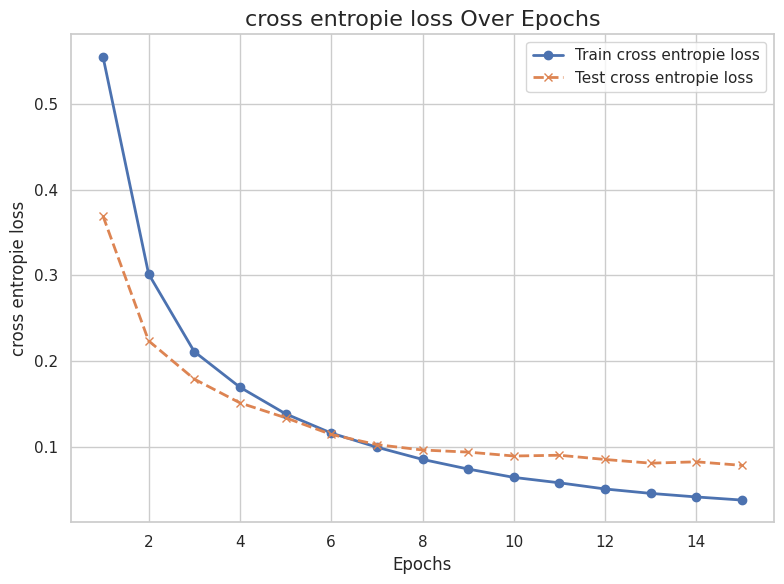

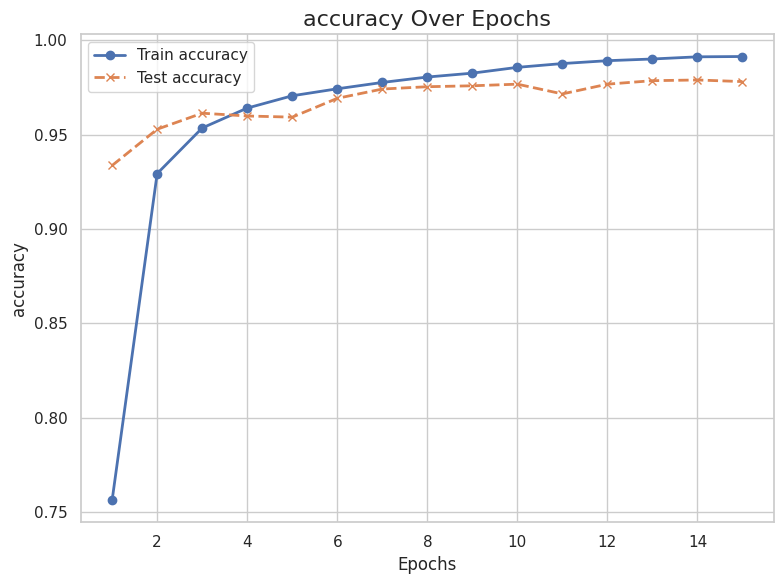

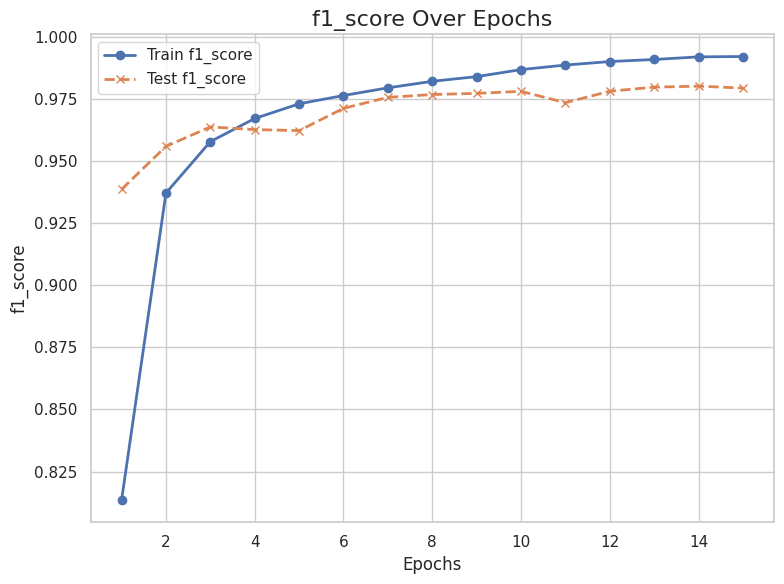

In [41]:
trainer.plot_metrics(list_train_loss, list_eval_loss, "cross entropie loss")
trainer.plot_metrics(list_train_accuracy, list_eval_accuracy , "accuracy")
trainer.plot_metrics(list_train_f1, list_eval_f1, "f1_score")


### Question 9 :
Evaluer le model sur les données test et exhiber des exemples d'articles prédit avec un mauvais label. 


In [42]:
#Chargement des modèles entrainés

#model_name = "TextClassifierMean_20250130_1631.checkpoint.pth"
checkpoint_path = os.path.join("../models_checkpoints/tp1",model_name)

w2v_model = Word2Vec.load("../models_checkpoints/tp1/fakenews_word2vec.model")


model= TextClassifierMean(vocab_size, embedding_dim,w2v_model, num_classes)
model.load_state_dict(torch.load(checkpoint_path,weights_only=False))
model.to(device)

Nombre de mots or vocabulaire pour le model d'embedding 509


TextClassifierMean(
  (embedding): Embedding(25001, 100)
  (drop): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

#### Evaluation du model sur le jeu de données test 

In [43]:
# Evaluation du modèle de classification sur les données test
model.eval()
total_test_loss = 0.0
total_test_samples = 0

correct_predictions_test = 0

predict_labels_test_list = []
targets_test_list = []

with torch.no_grad():
    for batch in test_dataloader:

        input_ids = batch['input_ids'].to(device)
        targets = batch["labels"].to(device)

        outputs = model(input_ids).to(device)
        test_loss = criterion(outputs, targets)

        total_test_loss += test_loss.item() * len(input_ids)
        total_test_samples += len(input_ids)

        predicted_labels = torch.argmax(outputs, dim=1)

        correct_predictions_test += (predicted_labels == targets).sum().item() #compte le nb de bonne prédiction

        predict_labels_test_list.extend(predicted_labels.tolist())
        targets_test_list.extend(targets.tolist())
       

loss_test = total_test_loss/total_test_samples


accuracy_test = correct_predictions_test / total_test_samples
precision_test = precision_score(targets_test_list, predict_labels_test_list)
recall_test = recall_score(targets_test_list, predict_labels_test_list)
f1_score_test =  f1_score(targets_test_list, predict_labels_test_list)


In [44]:
# Print the metrics in a clear format
print(f"Test Metrics:")
print(f"Loss: {loss_test:.4f}")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1 Score: {f1_score_test:.4f}")

Test Metrics:
Loss: 0.0696
Accuracy: 0.9826
Precision: 0.9826
Recall: 0.9851
F1 Score: 0.9839


#### Visualisation des mauvaises predictions 

In [45]:

def prediction_for_row(row,tokenizer,model):

    input_ids = tokenizer.encode(row['content']).ids

    # Convert the input to tensors
    input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)  # Add batch dimension

    # Set the model to eval mode
    model.eval()

    # Predict
    with torch.no_grad():
        outputs = model(input_ids)
        predicted_label = torch.argmax(outputs, dim=-1).item()
    
    return predicted_label

# Partial function to pass fixed arguments
predict_fn = partial(prediction_for_row,tokenizer=tokenizer, model=model)  


# Map the prediction function to each row
test_dataset = test_dataset.map(lambda row: {"predict_label": predict_fn(row)}, batched=False)

# Optionally convert back to a pandas DataFrame if needed
test_dataframe = test_dataset.to_pandas()


Map: 100%|██████████| 8117/8117 [00:10<00:00, 746.45 examples/s]


In [46]:
error_prediction_df = test_dataframe[test_dataframe["label"] != test_dataframe["predict_label"]]
good_prediction_df = test_dataframe[test_dataframe["label"] == test_dataframe["predict_label"]]

display_random_sample(error_prediction_df[['title', 'text', 'label','predict_label']],1) 
display_random_sample(good_prediction_df[['title', 'text', 'label','predict_label']],1) 


,title,text,label,predict_label
5346,years later elizabeth smart realizes kidnapping was even worse for her parents,lies and more liescannot trust any of those liars,1,0


,title,text,label,predict_label
127,"Trump team talks trade, labor with U.S. farm groups","CHICAGO (Reuters) - Advisers to Republican presidential nominee Donald Trump pledged to U.S. agricultural groups that he will give growers and states a say on national farm policy should he be elected, two association leaders said on Friday. Eleven groups representing farmers, seed companies and other players in the sector met for the first time with Trump’s top agricultural advisers in Washington on Monday to make recommendations on policy, following a similar meeting with representatives of rival Democratic nominee Hillary Clinton in June. The presidential candidates’ agriculture policies are crucial, agricultural groups say, because net U.S. farm income this year is forecast to drop to its lowest since 2002, largely due to a decline in grain prices. If that happens, incomes will be down 56 percent from a recent high of $123.3 billion in 2013. For Trump’s team, the meeting came as he has tried to be more disciplined and on message as he seeks to reset his campaign against Clinton for the Nov. 8 election. He reshuffled top campaign leaders this week, and on Friday accepted the resignation of campaign chairman Paul Manafort. Agricultural trade, labor, crop insurance and food safety were among the topics discussed at the meeting with farm groups, which included Charles Herbster, national chairman of Trump’s agricultural advisory committee, and Sam Clovis, Trump’s chief policy advisor, participants told Reuters. Former Nebraska Governor Dave Heineman, who is on Trump’s advisory committee, also attended, they said. “There was an assertion that farmers will be at the tables to make decisions, and that was well received by myself and our colleagues,” said Barb Glenn, chief executive officer of the National Association of State Departments of Agriculture. Also, there was a focus on “the concept that the states need to be brought in to work with the federal government,” she said. Clinton’s campaign staff have previously made similar comments to farm groups, said Jay Vroom, chief executive officer of pesticide association CropLife America, who attended meetings with representatives of both candidates. “Both of them are quite interested in understanding where American ag is at,” he said. Trump on Tuesday named 64 people to his agricultural advisory committee, including six U.S. governors, a former U.S. Department of Agriculture secretary, and the chairmen of the U.S. House and Senate agriculture committees. The latest RealClearPolitics average of national opinion polls puts Clinton 6 percentage points ahead of Trump, at 47.2 percent to 41.7 percent.",1,1


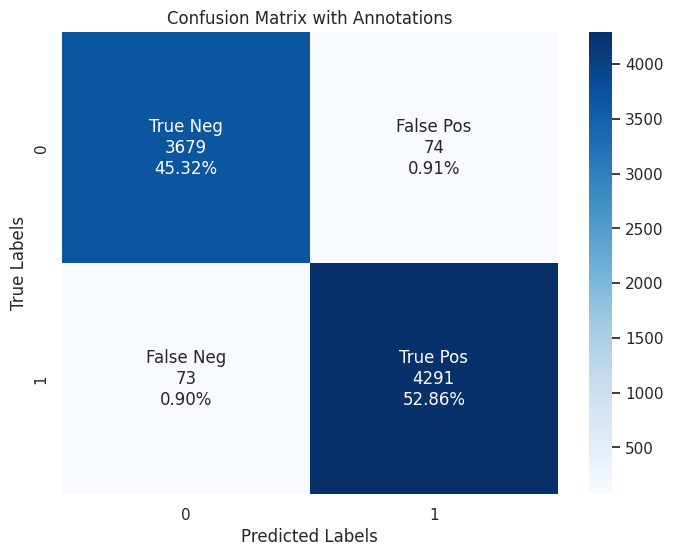

In [47]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

##link : https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

# Generate the confusion matrix
y_true = test_dataframe.label.values
y_pred = test_dataframe.predict_label.values
confu_mat = confusion_matrix(y_true, y_pred)

# Define group names
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

# Compute counts for each group
group_counts = ["{0:0.0f}".format(value) for value in confu_mat.flatten()]

# Compute percentages for each group
group_percentages = ["{0:.2%}".format(value) for value in confu_mat.flatten() / np.sum(confu_mat)]

# Combine names, counts, and percentages into a single label
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]

# Reshape labels to match the confusion matrix shape
labels = np.asarray(labels).reshape(confu_mat.shape)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confu_mat, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion Matrix with Annotations')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


### Projection des sentences embedding avec label 

In [50]:
def get_sentence_emb(batch):
    # Set the model to eval mode
    model.eval()

    # Predict
    with torch.no_grad():
        outputs =  torch.mean(model.embedding(batch["input_ids"].to(device)), axis=1)
    
    return {
        "sentence_embedding": outputs.to("cpu").detach(),
        "labels":batch["labels"].detach()
    }

sentences_embeddings = torch.tensor([])
labels =  torch.tensor([])

for batch in test_dataloader:
    out = get_sentence_emb(batch)
    sentences_embeddings = torch.cat((sentences_embeddings,out["sentence_embedding"]))
    labels = torch.cat((labels,out["labels"]))

In [51]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(sentences_embeddings.numpy())

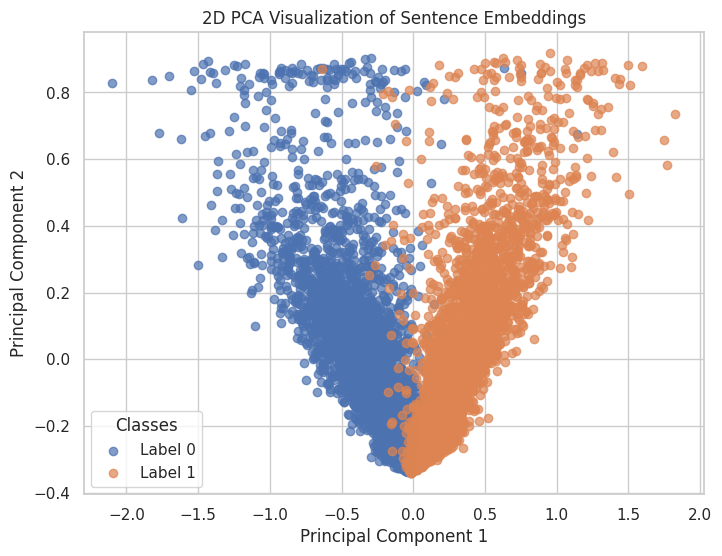

In [52]:

# Convert labels to integers if needed (in case they are strings)
unique_labels = np.unique(labels).astype(int)

# Create scatter plot with a legend
plt.figure(figsize=(8, 6))
for label in unique_labels:
    mask = labels == label  # Select points belonging to this label
    plt.scatter(components[mask, 0], components[mask, 1], label=f"Label {label}", alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Visualization of Sentence Embeddings')
plt.legend(title="Classes", loc='best')
plt.show()

### Proposer votre des exemples d'articles aliant fake-news et vrais articles et observez comment votre modèle généralise son apprentissage. 

In [53]:
#link = https://library-nd.libguides.com/fakenews/examples

content_fake = """
Hey Facebook, As some of you may know, I'm Bill Gates. If you click that share link, I will give you $5,000. 
I always deliver, I mean, I brought you Windows XP, right?
"""

row = {
    "content" : content_fake}

label = predict_fn(row)

print(label)

0


In [54]:
content_fake = """
On 15 May 2014, the National Report published an article reporting that Barack Obama had (in defiance of constitutional provisions) shockingly proclaimed he would be seeking a third term as President of the United States:

President Barack Obama shocked the country this morning with news that he is running for a third term

"I can't abandon the American people now when they need me more than ever," Obama told reporters at a press conference this morning. "We've come this far as a nation, now is not the time to do something different. This is the change you wanted and this is the change you’re getting." 

"""

row = {
    "content" : content_fake}

label = predict_fn(row)

print(label)

0


In [55]:
#link = https://www.bbc.com/news/articles/cq5eewvy3nlo

content_true= """
Donald Trump was rushed to safety on Sunday after what the FBI termed an apparent assassination attempt at his golf course in West Palm Beach, Florida.

Ryan Wesley Routh, 58, was arrested and charged with firearms offences.

The incident comes almost exactly two months after a shooting at a Trump rally in Butler, Pennsylvania, which left the Republican nominee with minor injuries and killed a man in the crowd.

Here is what we know so far about Sunday.
How was the suspect spotted?

The incident unfolded at the Trump International Golf Club in West Palm Beach, about 15 minutes from Trump's Florida residence, Mar-a-Lago.

A gunman was first seen by Secret Service agents, who were sweeping the course. Agents usually go one hole ahead to perform security checks, according to police.

The muzzle of a rifle - an SKS semi-automatic - was spotted sticking through the shrubbery that lines the course.

At the time, Trump was about 300-500 yards (275-460m) away from the spot.

An agent "immediately engaged" with the person holding the rifle, who fled, Sheriff Rik Bradshaw said. The suspect did not fire his weapon during the incident.

On 16 September, acting Secret Service director Ron Rowe said Trump was "across the course and out of sight of the sixth green" when the Secret Service agent opened fire.

At no point is the suspect believed to have had a clear line of sight to the former president.

Records show that Routh's phone had been in the area for about 12 hours, from around 02:00 to 13:31 local time, according to court documents and police officials. 

"""

row = {
    "content" : content_true}

label = predict_fn(row)

print(label)

0


In [56]:
#link = https://www.bbc.com/news/articles/cr56gr6p49eo

content_true="""Russia claims that its forces have captured the front-line town of Kurakhove in eastern Ukraine's Donetsk region.

The town has borne the brunt of Russian advances in recent months and is a stepping-stone to the key logistical hub of Pokrovsk.

Ukraine has not acknowledged the fall of Kurakhove, which is 35km (21 miles) south of Pokrovsk.

Fierce fighting has also been under way in Russia's Kursk region in recent days after Ukraine launched a counter-attack on Sunday.

An image taken from social media and supplied by the Reuters news agency appears to show a soldier holding up a Russian flag in Kurakhove. The image has not been verified by the BBC.

Viktor Trehubov, spokesperson for Ukraine's Khortytsia group of forces, told Reuters news agency that, as of Monday morning, Ukrainian forces were still engaging Russian troops inside Kurakhove.

Kurakhove is linked to Pokrovsk by roads that are part of the infrastructure to move troops and supplies along the front line.

The taking of Kurakhove would allow the Russians to go north to attack Pokrovsk from a new direction, analyst Roman Pohorily said.

Russia's defence ministry also claimed on Monday that the village of Dachenske, which about 8km south of Pokrovsk, had been captured by its forces.

Kyiv's forces are reportedly suffering from manpower shortages and have been losing ground in the east of Ukraine in recent months, as Russian troops advance.

"""

row = {
    "content" : content_true}

label = predict_fn(row)

print(label)

1
